In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt

import os
# print(os.listdir("./data_sets"))

import torch
import torch.nn as nn

'''
    准备数据
'''
# 读取训练数据集
raw_data = pd.read_csv('./data_sets/kaggle_house_train.csv')

# 生成非字符串数据的描述性统计信息。它默认返回数据的计数、平均值、标准差、最小值、25%分位数（第一四分位数）、50%分位数（中位数）、75%分位数（第三四分位数）和最大值。
#                 Id   MSSubClass  LotFrontage        LotArea  OverallQual  \
# count  1460.000000  1460.000000  1201.000000    1460.000000  1460.000000   
# mean    730.epoch000    56.897260    70.049958   10516.828082     6.099315   
# std     421.610009    42.300571    24.284752    9981.264932     1.382997   
# min       1.000000    20.000000    21.000000    1300.000000     1.000000   
# 25%     365.7epoch00    20.000000    59.000000    7553.epoch000     5.000000   
# 50%     730.500000    50.000000    69.000000    9478.500000     6.000000   
# 75%    1095.250000    70.000000    80.000000   11601.500000     7.000000   
# max    1460.000000   190.000000   313.000000  215245.000000    10.000000   
raw_data.describe()
# 显示查看头部前十条数据
raw_data.head(10)
# print(raw_data.head(10))

# 数字类字段整理
numeric_colmuns = []
numeric_colmuns.extend(list(raw_data.dtypes[raw_data.dtypes == np.int64].index))
numeric_colmuns.extend(list(raw_data.dtypes[raw_data.dtypes == np.float64].index))
print(numeric_colmuns)
numeric_colmuns.remove('SalePrice')
numeric_colmuns.append('SalePrice')
numeric_colmuns.remove('Id')

# 数字类型数据整理
numeric_data = DataFrame(raw_data, columns=numeric_colmuns)
numeric_data.describe()
numeric_data.head(10)
print(numeric_data.head(10))

# 查出所有数据中包含 'NA' 的列
nan_columns = np.any(pd.isna(numeric_data), axis = 0)
nan_columns = list(nan_columns[nan_columns == True].index)
print(nan_columns)

# 把包含 'NA' 的数据都填充成0
numeric_data['LotFrontage'] = numeric_data['LotFrontage'].fillna(0)
numeric_data['MasVnrArea'] = numeric_data['MasVnrArea'].fillna(0)
numeric_data['GarageYrBlt'] = numeric_data['GarageYrBlt'].fillna(0)

# 再次检查是否有非法数据字段
nan_columns = np.any(pd.isna(numeric_data), axis = 0)
nan_columns = list(nan_columns[nan_columns == True].index)
print(nan_columns)

# 准备训练数据和labels
numeric_x_columns = list(numeric_data.columns)
numeric_x_columns.remove('SalePrice')
numeric_y_columns = ['SalePrice']
print(numeric_x_columns)

numeric_x_df = DataFrame(numeric_data, columns=numeric_x_columns)
numeric_y_df = DataFrame(numeric_data, columns=numeric_y_columns)
numeric_x = torch.tensor(numeric_x_df.values, dtype=torch.float)
numeric_y = torch.tensor(numeric_y_df.values, dtype=torch.float)
print(numeric_x.shape)
print(numeric_y.shape)


['Id', 'MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice', 'LotFrontage', 'MasVnrArea', 'GarageYrBlt']
   MSSubClass  LotArea  OverallQual  OverallCond  YearBuilt  YearRemodAdd  \
0          60     8450            7            5       2003          2003   
1          20     9600            6            8       1976          1976   
2          60    11250            7            5       2001          2002   
3          70     9550            7            5       1915          1970   
4          60    14260            8            5       2000          2000   
5          50    1

In [2]:
'''
    构建感知机
'''

class Net(nn.Module):
    '''
        基础感知机网络搭建
    '''
    def __init__(self, D_in, H1, H2, H3, D_out):
        super(Net, self).__init__()
        
        self.linear1 = nn.Linear(D_in, H1)
        self.linear2 = nn.Linear(H1, H2)
        self.linear3 = nn.Linear(H2, H3)
        self.linear4 = nn.Linear(H3, D_out)
        
    def forward(self, x):
        y_pred = self.linear1(x).clamp(min=0)
        y_pred = self.linear2(y_pred).clamp(min=0)
        y_pred = self.linear3(y_pred).clamp(min=0)
        y_pred = self.linear4(y_pred)
        return y_pred

# 定义隐藏层
H1, H2, H3 = 500, 1000, 200

epoch = 500

In [3]:
# 定义输入层和输出层
D_in, D_out = numeric_x.shape[1], numeric_y.shape[1]
model1 = Net(D_in, H1, H2, H3, D_out)
# reduction="none"：求所有对应位置的差的平方，返回的仍然是一个和原来形状一样的矩阵。
# reduction="mean"：求所有对应位置差的平方的均值，返回的是一个标量。
# reduction="sum"：求所有对应位置差的平方的和，返回的是一个标量。
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(model1.parameters(), lr=1e-4)

losses1 = []

for t in range(epoch):
    y_pred = model1(numeric_x)
    
    loss = criterion(y_pred, numeric_y)
    print(t, loss.item())
    losses1.append(loss.item())
    
    # 判断输入的张量是否为空
    if torch.isnan(loss):
        break
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


0 56975857549312.0
1 inf
2 nan


数据标准化处理

In [12]:
# 平均值，最大值，最小值
means, maxs, mins = dict(), dict(), dict()
for col in numeric_data:
    means[col] = numeric_data[col].mean()
    maxs[col] = numeric_data[col].max()
    mins[col] = numeric_data[col].min()

# 减去均值除以标准差，将原始数据转换为标准取值，做数据标准化
numeric_data = (numeric_data - numeric_data.mean()) / (numeric_data.max() - numeric_data.min())
numeric_x_df = DataFrame(numeric_data, columns=numeric_x_columns)
numeric_y_df = DataFrame(numeric_data, columns=numeric_y_columns)
numeric_x = torch.tensor(numeric_x_df.values, dtype=torch.float)
numeric_y = torch.tensor(numeric_y_df.values, dtype=torch.float)

print(numeric_data)

model2 = Net(D_in, H1, H2, H3, D_out)
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(model2.parameters(), lr=1e-4)

losses2 = []

for t in range(epoch):
    y_pred = model2(numeric_x)
    
    loss = criterion(y_pred, numeric_y)
    # print(t, loss.item())
    losses2.append(loss.item())
    
    if torch.isnan(loss):
        break
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

plt.figure(figsize=(12, 10))
plt.plot(range(len(losses2)), losses2)
plt.show()


      MSSubClass   LotArea  OverallQual  OverallCond  YearBuilt  YearRemodAdd  \
0       0.018251 -0.009661     0.100076    -0.071918   0.229943      0.302237   
1      -0.217043 -0.004285    -0.011035     0.303082   0.034291     -0.147763   
2       0.018251  0.003427     0.100076    -0.071918   0.215451      0.285571   
3       0.077075 -0.004519     0.100076    -0.071918  -0.407738     -0.247763   
4       0.018251  0.017496     0.211187    -0.071918   0.208204      0.252237   
...          ...       ...          ...          ...        ...           ...   
1455    0.018251 -0.012152    -0.011035    -0.071918   0.200958      0.252237   
1456   -0.217043  0.012425    -0.011035     0.053082   0.048784      0.052237   
1457    0.077075 -0.006893     0.100076     0.428082  -0.219332      0.352237   
1458   -0.217043 -0.003738    -0.122146     0.053082  -0.154115      0.185571   
1459   -0.217043 -0.002710    -0.122146     0.053082  -0.045419     -0.331096   

      BsmtFinSF1  BsmtFinSF

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1460x36 and 79x500)

调节学习率

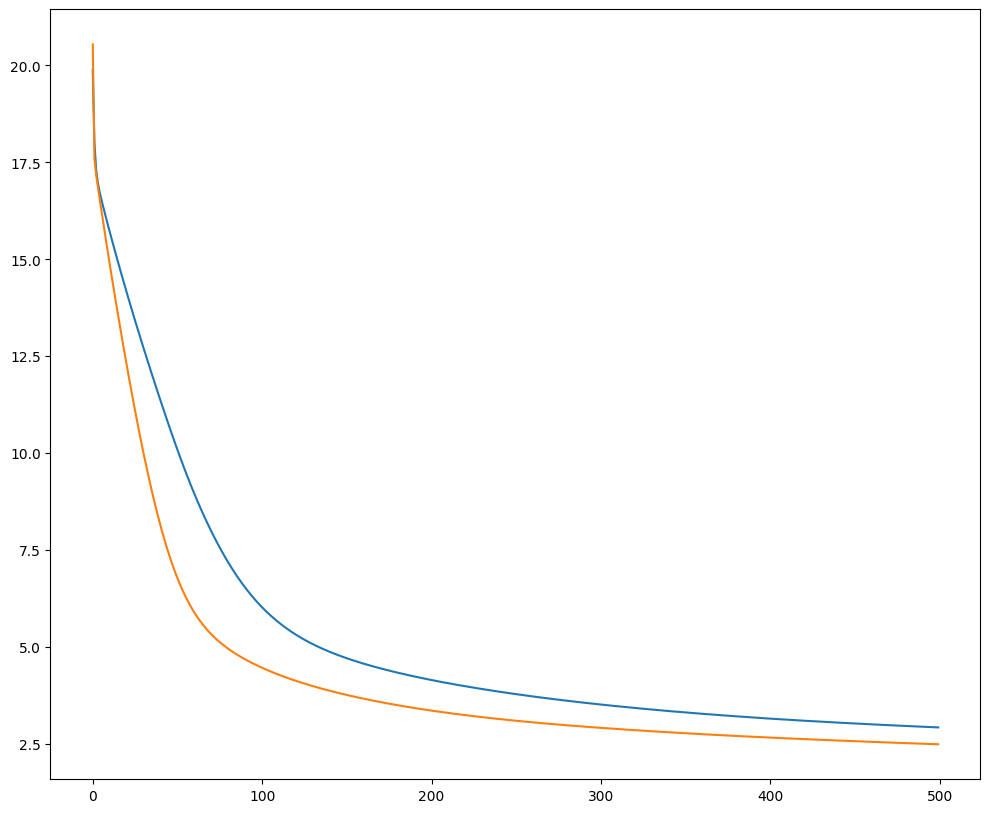

In [5]:
model3 = Net(D_in, H1, H2, H3, D_out)
optimizer = torch.optim.SGD(model3.parameters(), lr=1e-4 * 2)
losses3 = []

for t in range(epoch):
    y_pred = model3(numeric_x)
    
    loss = criterion(y_pred, numeric_y)
    # print(t, loss.item())
    losses3.append(loss.item())
    
    if torch.isnan(loss):
        break
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

plt.figure(figsize=(12, 10))
plt.plot(range(len(losses2)), losses2)
plt.plot(range(len(losses3)), losses3)
plt.show()


将激活函数更换为Adam

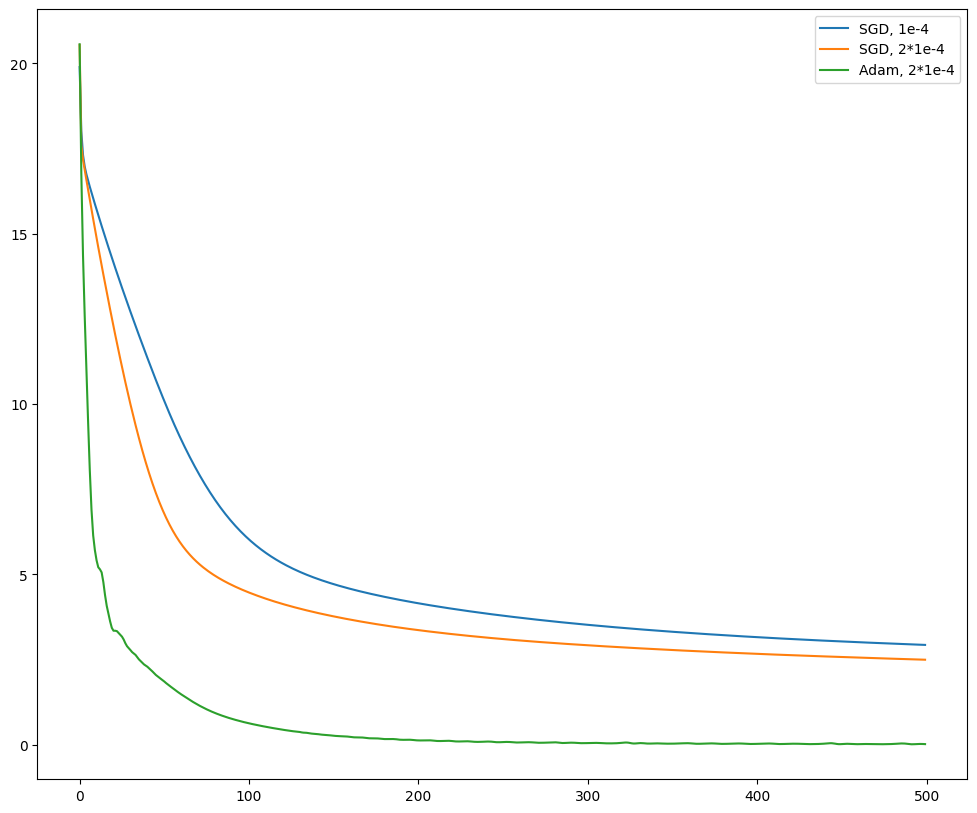

In [6]:
model4 = Net(D_in, H1, H2, H3, D_out)
optimizer = torch.optim.Adam(model4.parameters(), lr=1e-4 * 2)
losses4 = []

for t in range(epoch):
    y_pred = model4(numeric_x)
    
    loss = criterion(y_pred, numeric_y)
    # print(t, loss.item())
    losses4.append(loss.item())
    
    if torch.isnan(loss):
        break
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

plt.figure(figsize=(12, 10))
plt.plot(range(len(losses2)), losses2, label='SGD, 1e-4')
plt.plot(range(len(losses3)), losses3, label='SGD, 2*1e-4')
plt.plot(range(len(losses4)), losses4, label = 'Adam, 2*1e-4')

plt.legend(loc='upper right')
plt.show()

处理字符串类型字段的数据

In [7]:
non_numeric_columns = [col for col in list(raw_data.columns) if col not in numeric_colmuns]
non_numeric_columns.remove('Id')
print(non_numeric_columns)

non_numeric_data = DataFrame(raw_data, columns=non_numeric_columns)
non_numeric_data.describe()
non_numeric_data.head(10)
nan_columns = np.any(pd.isna(non_numeric_data), axis=0)
nan_columns = list(nan_columns[nan_columns == True].index)
print(nan_columns)

for col in nan_columns:
    non_numeric_data[col] = non_numeric_data[col].fillna('N/A')

nan_columns = np.any(pd.isna(non_numeric_data), axis = 0)
nan_columns = list(nan_columns[nan_columns == True].index)
print(nan_columns)

mapping_table = dict()

for col in non_numeric_columns:
    curr_mapping_table = dict()
    
    # 获取唯一值
    unique_values = pd.unique(non_numeric_data[col])
    # 有多少值就增加多少对应关系，数字从1开始计数，递增步长为1
    for inx, v in enumerate(unique_values):
        curr_mapping_table[v] = inx + 1
        non_numeric_data[col] = non_numeric_data[col].replace(v, inx + 1)
    
    mapping_table[col] = curr_mapping_table

print(mapping_table)

print(non_numeric_data.head(10))


['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']
['Alley', 'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']
[]
{'MSZoning': {'RL': 1, 'RM': 2, 'C (all)': 3, 'FV': 4, 'RH': 5}, 'Street': {'Pave': 1, 'Grvl': 2}, 'Alley': {'N/A': 1, 'Grvl': 2, 'Pave': 3}, 'LotShape': {'Reg': 1, 'IR1': 2, 'IR2': 3, 'IR3': 4}, 'Lan

使用字符串类型的字段训练

0 19.11764144897461
1 17.05052375793457
2 16.05509376525879
3 14.960289001464844
4 13.738970756530762
5 12.686633110046387
6 11.90184497833252
7 11.215847969055176
8 10.527073860168457
9 10.003955841064453
10 9.731085777282715
11 9.465996742248535
12 9.179129600524902
13 9.019561767578125
14 8.8330659866333
15 8.557868957519531
16 8.358831405639648
17 8.189130783081055
18 7.975983142852783
19 7.834092140197754
20 7.726717472076416
21 7.575130939483643
22 7.4517903327941895
23 7.330596923828125
24 7.164487838745117
25 7.017232894897461
26 6.873626708984375
27 6.704788684844971
28 6.559676170349121
29 6.4172492027282715
30 6.260058403015137
31 6.120097637176514
32 5.969243049621582
33 5.8112945556640625
34 5.668704032897949
35 5.520797252655029
36 5.383730411529541
37 5.252407550811768
38 5.113207817077637
39 4.981956958770752
40 4.840201377868652
41 4.706716537475586
42 4.575129508972168
43 4.453362464904785
44 4.336288928985596
45 4.220543384552002
46 4.104104995727539
47 3.98886656761

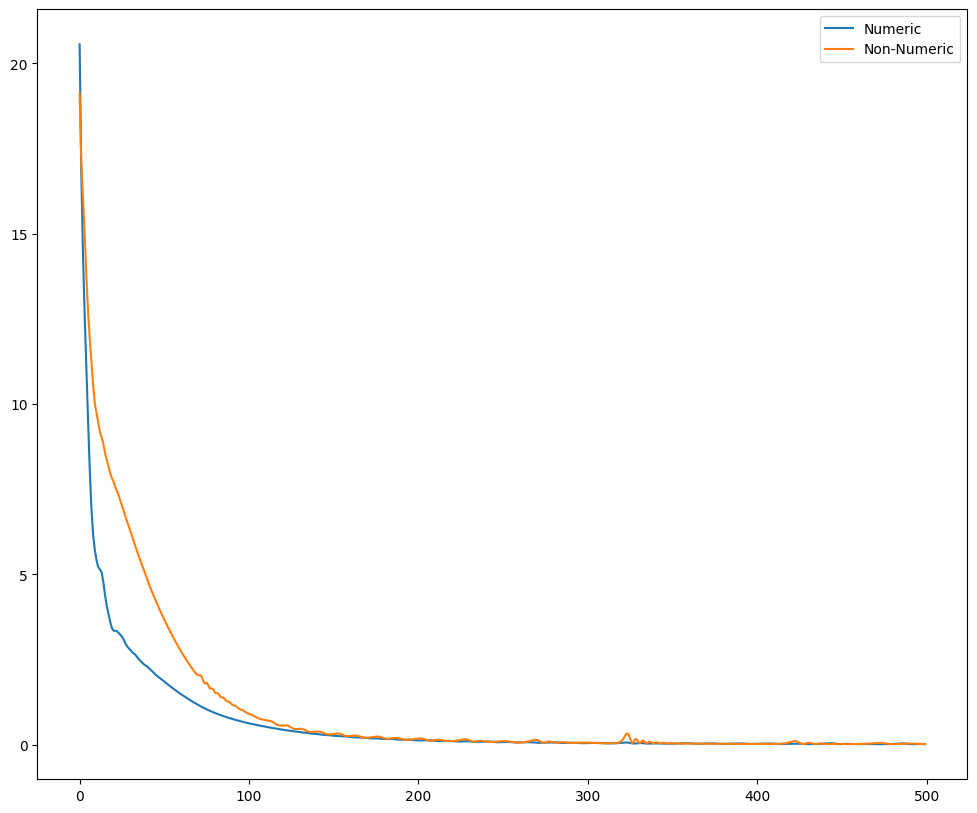

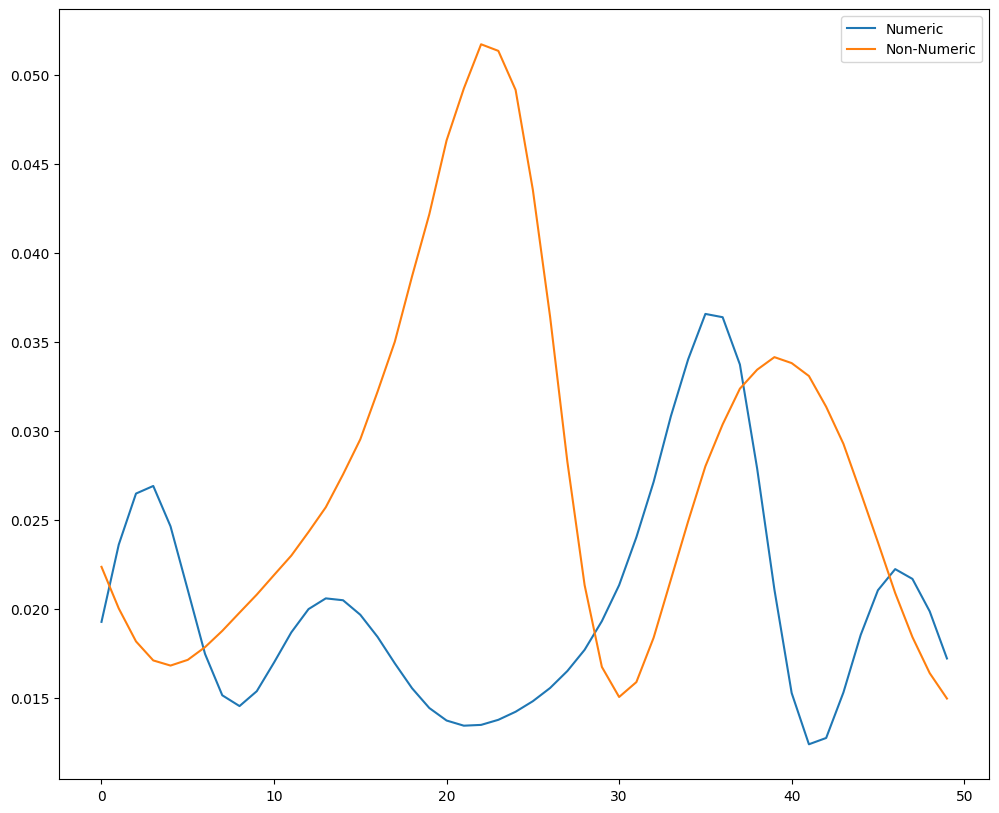

In [8]:
# 标准化数据
for col in non_numeric_data:
    means[col] = non_numeric_data[col].mean()
    maxs[col] = non_numeric_data[col].max()
    mins[col] = non_numeric_data[col].min()

non_numeric_data = (non_numeric_data - non_numeric_data.mean()) / (non_numeric_data.max() - non_numeric_data.min())

non_numeric_x_df = DataFrame(non_numeric_data, columns=non_numeric_columns)
non_numeric_y_df = DataFrame(numeric_y_df)
non_numeric_x = torch.tensor(non_numeric_x_df.values, dtype=torch.float)
non_numeric_y = torch.tensor(non_numeric_y_df.values, dtype=torch.float)

D_in, D_out = non_numeric_x.shape[1], non_numeric_y.shape[1]
model5 = Net(D_in, H1, H2, H3, D_out)
optimizer = torch.optim.Adam(model5.parameters(), lr=1e-4 * 2)

losses5 = []

for t in range(epoch):
    y_pred = model5(non_numeric_x)
    
    loss = criterion(y_pred, non_numeric_y)
    print(t, loss.item())
    losses5.append(loss.item())
    
    if torch.isnan(loss):
        break
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

plt.figure(figsize=(12, 10))
plt.plot(range(len(losses4)), losses4, label = 'Numeric')
plt.plot(range(len(losses5)), losses5, label = 'Non-Numeric')

plt.legend(loc='upper right')
plt.show()

# 最后五十次训练的损失对比图
plt.figure(figsize=(12, 10))
plt.plot(range(len(losses4[-50:])), losses4[-50:], label = 'Numeric')
plt.plot(range(len(losses5[-50:])), losses5[-50:], label = 'Non-Numeric')

plt.legend(loc='upper right')
plt.show()



使用全数据训练

0 17.611970901489258
1 15.348398208618164
2 13.483471870422363
3 11.762406349182129
4 10.119314193725586
5 8.631773948669434
6 7.399462699890137
7 6.475353240966797
8 5.834590911865234
9 5.46843957901001
10 5.320664405822754
11 5.183528423309326
12 4.9468159675598145
13 4.638944625854492
14 4.2757134437561035
15 3.9090499877929688
16 3.6347012519836426
17 3.471527099609375
18 3.3835089206695557
19 3.346503734588623
20 3.3025577068328857
21 3.210726261138916
22 3.0816009044647217
23 2.925241708755493
24 2.764026641845703
25 2.633995294570923
26 2.5426807403564453
27 2.48787260055542
28 2.455350160598755
29 2.411849021911621
30 2.348496675491333
31 2.267524003982544
32 2.179784059524536
33 2.1042656898498535
34 2.042541980743408
35 1.9919334650039673
36 1.9453577995300293
37 1.8915491104125977
38 1.8337080478668213
39 1.7742735147476196
40 1.7205328941345215
41 1.6757169961929321
42 1.6333705186843872
43 1.5886712074279785
44 1.5362478494644165
45 1.481561303138733
46 1.4300906658172607


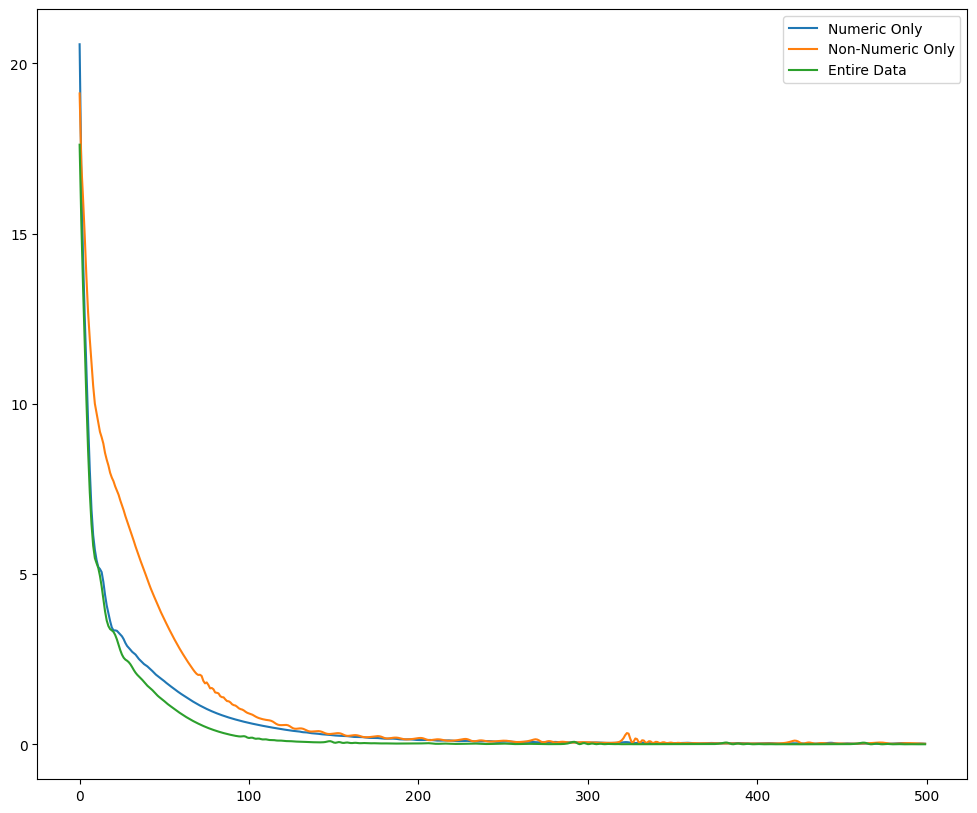

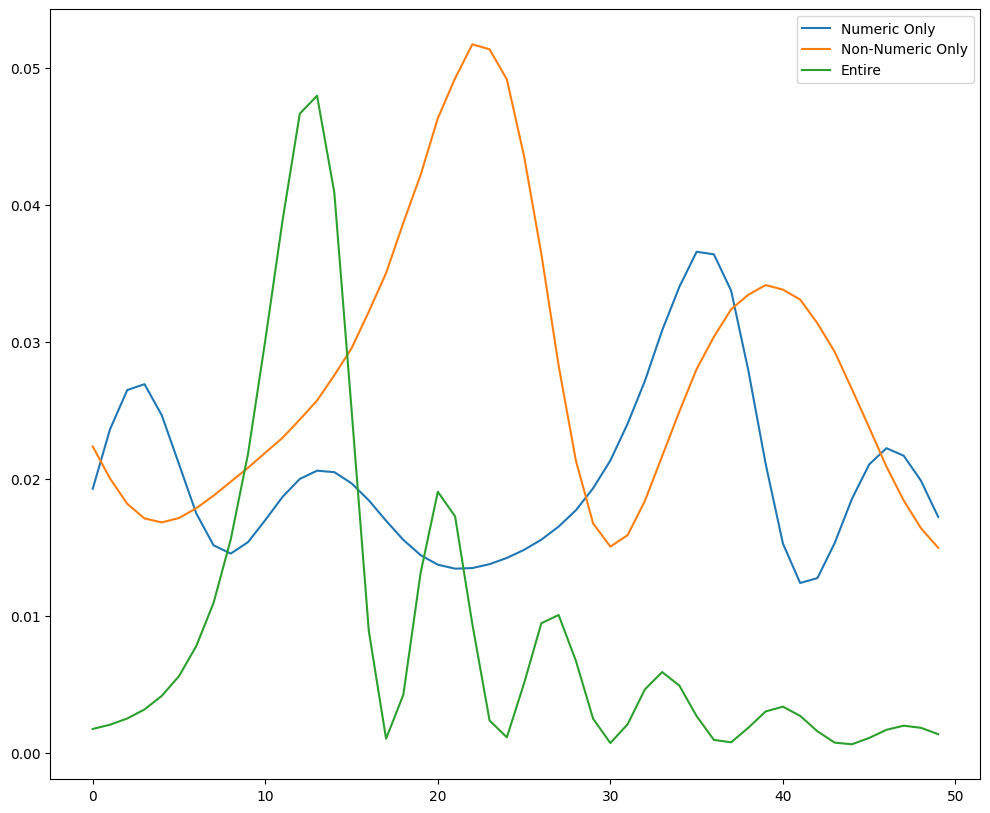

In [9]:
x_df = DataFrame(numeric_x_df, columns=numeric_x_columns)
y_df = DataFrame(numeric_y_df)

for col in non_numeric_columns:
    x_df[col] = non_numeric_x_df[col]

x_df.head()

x = torch.tensor(x_df.values, dtype=torch.float)
y = torch.tensor(y_df.values, dtype=torch.float)

D_in, D_out = x.shape[1], y.shape[1]
model6 = Net(D_in, H1, H2, H3, D_out)
optimizer = torch.optim.Adam(model6.parameters(), lr=1e-4 * 2)

losses6 = []

for t in range(epoch):
    y_pred = model6(x)
    
    loss = criterion(y_pred, y)
    print(t, loss.item())
    losses6.append(loss.item())
    
    if torch.isnan(loss):
        break
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
plt.figure(figsize=(12, 10))
plt.plot(range(len(losses4)), losses4, label = 'Numeric Only')
plt.plot(range(len(losses5)), losses5, label = 'Non-Numeric Only')
plt.plot(range(len(losses6)), losses6, label = 'Entire Data')

plt.legend(loc='upper right')
plt.show()

plt.figure(figsize=(12, 10))
plt.plot(range(len(losses4[-50:])), losses4[-50:], label = 'Numeric Only')
plt.plot(range(len(losses5[-50:])), losses5[-50:], label = 'Non-Numeric Only')
plt.plot(range(len(losses6[-50:])), losses6[-50:], label = 'Entire')

plt.legend(loc='upper right')
plt.show()



验证数据

In [10]:
# test data
raw_test_data = pd.read_csv('./data_sets/kaggle_house_test.csv')
raw_test_data.describe()
raw_test_data.head(10)
test_x = DataFrame(raw_test_data)
test_x = test_x.drop(columns=['Id'])
for col in numeric_x_columns:
    test_x[col].fillna(0)

for col in non_numeric_columns:
    test_x[col] = test_x[col].fillna('N/A')

test_x.head()

for col in mapping_table.keys():
    curr_mapping_table = mapping_table[col]
    for k, v in curr_mapping_table.items():
        test_x[col] = test_x[col].replace(k, v)

test_x.head(10)

unreplaced_columns = []

for col in test_x.columns:
    if 'N/A' in pd.unique(test_x[col]):
        unreplaced_columns.append(col)
        
print(unreplaced_columns)

for col in unreplaced_columns:
    test_x[col] = test_x[col].replace('N/A', 0)

for col in test_x.columns:
    test_x[col] = (test_x[col] - means[col]) / (maxs[col] - mins[col])

test_y = model6(torch.tensor(test_x.values, dtype=torch.float))
result = DataFrame(test_y.data.numpy(), columns=['SalePrice'])
result['SalePrice'] = result['SalePrice'].fillna(0)
result['SalePrice'] = result['SalePrice'] * (maxs['SalePrice'] - mins['SalePrice']) + means['SalePrice']
result['Id'] = np.array(result.index)
result['Id'] = result['Id'] + 1461
result = DataFrame(result, columns=['Id', 'SalePrice'])

print(result)

['MSZoning', 'Utilities', 'Exterior1st', 'Exterior2nd', 'KitchenQual', 'Functional', 'SaleType']
        Id      SalePrice
0     1461  238755.862013
1     1462  221499.837004
2     1463  162394.418592
3     1464  171664.537838
4     1465  182886.775698
...    ...            ...
1454  2915  180921.195890
1455  2916  179226.854250
1456  2917  143013.316866
1457  2918  180921.195890
1458  2919  148934.410105

[1459 rows x 2 columns]


/tmp/ipykernel_3253332/1913231286.py:25: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'N/A' in pd.unique(test_x[col]):
